# Face Recognition - PubFig83

**D3APL – Aplicações em Ciência de dados**

Especialização em Ciência de Dados - IFSP Campinas

Alunos
- Daniel Vargas Shimamoto
- Diego Machado de Assis

# 1. Informações Gerais

## 1.1. Conhecendo  o dataset


## 1.2. Atributos:



## 1.3. Objetivo


# 2. Importações
## 2.1 Bibliotecas

In [1]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import os

# Visualização de imagem
import cv2
import matplotlib.pyplot as plt

## 2.2 Datasets

In [2]:
# Path das imagens
dataset_folder = '../Datasets'
imgs_folder = f'{dataset_folder}/imgs'

# Lista de pastas
class_folders = sorted(os.listdir(imgs_folder))
n_classes = len(class_folders)

print(f'Número de Classes: {n_classes}')

Número de Classes: 83


In [3]:
# Dataset de treino
df_train = pd.read_csv(f'{dataset_folder}/train.csv')

# Dataset de treino
df_test = pd.read_csv(f'{dataset_folder}/test.csv')

print(f'Train: {len(df_train)}')
print(f'Test: {len(df_test)}')

Train: 12178
Test: 1660


## 2.3 Visualização das imagens

In [4]:
def print_image(df, pos, dataset_folder=dataset_folder):
    img = cv2.imread(f'{dataset_folder}/{df.iloc[pos]["image_pathname"]}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

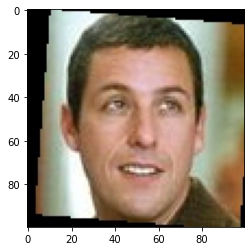

In [5]:
print_image(df_train, 5)

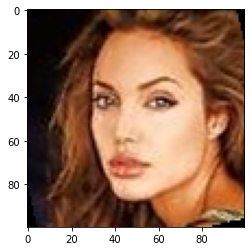

In [6]:
print_image(df_test, 50)

## 2.4 Atributos das imagens

In [7]:
def img_attrs(img_path, dataset_folder=dataset_folder):
    img = cv2.imread(f'{dataset_folder}/{img_path}')
    return [img.shape, (img.min(), img.max())]

In [8]:
attrs = df_train['image_pathname'].apply(img_attrs).apply(pd.Series)
attrs.columns = ['shape', 'colors']

attrs

,shape,colors
0,"(100, 100, 3)","(0, 255)"
1,"(100, 100, 3)","(0, 255)"
2,"(100, 100, 3)","(0, 244)"
3,"(100, 100, 3)","(0, 255)"
4,"(100, 100, 3)","(0, 255)"
...,...,...
12173,"(100, 100, 3)","(0, 236)"
12174,"(100, 100, 3)","(0, 255)"
12175,"(100, 100, 3)","(0, 255)"
12176,"(100, 100, 3)","(0, 255)"


In [9]:
attrs['shape'].unique()

array([(100, 100, 3)], dtype=object)

Todas imagens possuem o mesmo formato, de 100 x 100 x 3

In [10]:
colors_series = attrs['colors'].apply(pd.Series, dtype=np.uint8)
colors_series.min().min(), colors_series.max().max()

(0, 255)

As informações de cores variam de 0 a 255

## 2.5 Distribuição das classes

In [11]:
def images_in_class(cls, imgs_folder=imgs_folder):
    class_path = os.path.join(imgs_folder, cls)
    images = os.listdir(class_path)
    return len(images)

In [12]:
images_dict = { cls: images_in_class(cls) for cls in class_folders }
classes_images = pd.DataFrame.from_dict(images_dict, orient='index', columns=['Images'])
classes_images

,Images
Adam Sandler,108
Alec Baldwin,103
Angelina Jolie,214
Anna Kournikova,171
Ashton Kutcher,101
...,...
Uma Thurman,167
Victoria Beckham,134
Viggo Mortensen,112
Will Smith,128


In [13]:
print(f'Classe com menos imagens: {classes_images.Images.min()} imagens')
print(f'Classe com mais imagens: {classes_images.Images.max()} imagens')

Classe com menos imagens: 100 imagens
Classe com mais imagens: 367 imagens


# 3. Pré-processamento

## 3.1 Preparação dos dados

### 3.1.1 Adição de coluna com as classes nos datasets de treino e teste

In [14]:
df_train['class'] = df_train.loc[:, 'image_pathname'].str.split('/', expand=True).loc[:, 1]
df_test['class'] = df_test.loc[:, 'image_pathname'].str.split('/', expand=True).loc[:, 1]

In [15]:
df_train.sample(3)

,image_pathname,class
3721,imgs/Drew Barrymore/17.jpg,Drew Barrymore
2037,imgs/Charlize Theron/371.jpg,Charlize Theron
8619,imgs/Mickey Rourke/169.jpg,Mickey Rourke


In [16]:
df_test.sample(3)

,image_pathname,class
414,imgs/Daniel Radcliffe/54.jpg,Daniel Radcliffe
258,imgs/Charlize Theron/218.jpg,Charlize Theron
908,imgs/Julia Stiles/190.jpg,Julia Stiles


### 3.1.2 Criação de um dataset para validação do treinamento

In [17]:
# Dataframe com volume de amostras de treino e teste e a proporção entre eles
samples = pd.concat([df_train['class'].value_counts(), df_test['class'].value_counts()], axis=1)
samples.columns = ['Train samples', 'Test samples']
samples['Proportion'] = samples['Test samples'] / samples['Train samples']
samples

,Train samples,Test samples,Proportion
Miley Cyrus,347,20,0.057637
Lindsay Lohan,334,20,0.059880
Jessica Simpson,280,20,0.071429
Brad Pitt,280,20,0.071429
Avril Lavigne,279,20,0.071685
...,...,...,...
Mariah Carey,82,20,0.243902
Ashton Kutcher,81,20,0.246914
Jack Nicholson,81,20,0.246914
Robert Gates,80,20,0.250000


In [18]:
classes = df_train['class'].unique()
validation = pd.DataFrame(columns=['image_pathname', 'class'])

for cls in classes:
    cls_validation = df_train[df_train['class'] == cls].sample(20)
    validation = pd.concat([validation, cls_validation])

train = df_train.drop(index=validation.index)

test = df_test

In [19]:
samples = pd.concat([train['class'].value_counts(), validation['class'].value_counts(), test['class'].value_counts()], axis=1)
samples.columns = ['Train samples', 'Validation samples', 'Test samples']
samples

,Train samples,Validation samples,Test samples
Miley Cyrus,327,20,20
Lindsay Lohan,314,20,20
Jessica Simpson,260,20,20
Brad Pitt,260,20,20
Avril Lavigne,259,20,20
...,...,...,...
Mariah Carey,62,20,20
Ashton Kutcher,61,20,20
Jack Nicholson,61,20,20
Robert Gates,60,20,20


## 3.2 Undersampling dos dados de treinamento

In [20]:
n_desired_samples = 200

In [21]:
classes = df_train['class'].unique()
undersampled = pd.DataFrame(columns=['image_pathname', 'class'])

for cls in classes:
    cls_undersampled = train[train['class'] == cls].sample(frac=1)[:n_desired_samples]
    undersampled = pd.concat([undersampled, cls_undersampled])

train = undersampled

In [22]:
samples = pd.concat([train['class'].value_counts(), validation['class'].value_counts(), test['class'].value_counts()], axis=1)
samples.columns = ['Train samples', 'Validation samples', 'Test samples']
samples

,Train samples,Validation samples,Test samples
Jessica Simpson,200,20,20
Brad Pitt,200,20,20
Gwyneth Paltrow,200,20,20
Daniel Radcliffe,200,20,20
Katherine Heigl,200,20,20
...,...,...,...
Mariah Carey,62,20,20
Ashton Kutcher,61,20,20
Jack Nicholson,61,20,20
Robert Gates,60,20,20


In [23]:
samples.sum()

Train samples         9975
Validation samples    1660
Test samples          1660
dtype: int64

## 3.3 Pré-processamento

Carregamento dos arquivos de imagem e _feature scaling_

In [24]:
import cv2

def preprocess_dataset(dataset_df, label_encoder, dataset_folder=dataset_folder):
    image_list = []
    
    for index, img_path in enumerate(dataset_df['image_pathname']):
        img = cv2.imread(f'{dataset_folder}/{img_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        image_list.append(img)
        
        # verbose - print every 1000 iterations
        if index % 1000 == 0:
            print(f'{index + 1}/{dataset_df.shape[0]} - {img_path}')
    
    X = np.array(image_list)
    
    # feature scaling
    X = X / 255.0
    
    # encoding the classes
    y = label_encoder.fit_transform(dataset_df['class'])
    
    return X, y

In [25]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train['class'])

LabelEncoder()

In [26]:
print('Pre-processing the training set:')
X_train, y_train = preprocess_dataset(train, label_encoder)

print('\nPre-processing the validation set:')
X_validation, y_validation = preprocess_dataset(validation, label_encoder)

print('\nPre-processing the test set:')
X_test, y_test = preprocess_dataset(test, label_encoder)

Pre-processing the training set:
1/9975 - imgs/Adam Sandler/304.jpg
1001/9975 - imgs/Beyonce Knowles/144.jpg
2001/9975 - imgs/Clive Owen/48.jpg
3001/9975 - imgs/Denise Richards/184.jpg
4001/9975 - imgs/Halle Berry/480.jpg
5001/9975 - imgs/Jessica Simpson/340.jpg
6001/9975 - imgs/Keira Knightley/218.jpg
7001/9975 - imgs/Michael Bloomberg/27.jpg
8001/9975 - imgs/Reese Witherspoon/45.jpg
9001/9975 - imgs/Silvio Berlusconi/152.jpg

Pre-processing the validation set:
1/1660 - imgs/Adam Sandler/222.jpg
1001/1660 - imgs/Kiefer Sutherland/119.jpg

Pre-processing the test set:
1/1660 - imgs/Adam Sandler/34.jpg
1001/1660 - imgs/Kiefer Sutherland/40.jpg


In [27]:
for name, X, y in [
    ('train', X_train, y_train),
    ('validation', X_validation, y_validation),
    ('test', X_test, y_test)
]:
    print(f'X_{name}.shape: {X.shape}')
    print(f'y_{name}.shape: {y.shape}')
    print(f'y_{name} ({len(np.unique(y))} classes): {np.unique(y)}')
    

    # rescaled 24-bit color image
    print(f'Min. value of X_{name}: {X.min()}')
    print(f'Max. value of X_{name}: {X.max()}\n')

X_train.shape: (9975, 100, 100, 3)
y_train.shape: (9975,)
y_train (83 classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
Min. value of X_train: 0.0
Max. value of X_train: 1.0

X_validation.shape: (1660, 100, 100, 3)
y_validation.shape: (1660,)
y_validation (83 classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
Min. value of X_validation: 0.0
Max. value of X_validation: 1.0

X_test.shape: (1660, 100, 100, 3)
y_test.shape: (1660,)
y_test (83 classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

## 3.4 Balanceamento de classes (_data augmentation_)

In [28]:
n_samples = np.bincount(y_train)
classes = np.nonzero(n_samples)[0]

samples_per_class = list(zip(classes, n_samples))
samples_per_class[:5] # Tuples of (class, n_samples)

[(0, 68), (1, 63), (2, 174), (3, 131), (4, 61)]

In [29]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation

new_images = []
new_classes = []

# Random number generator
rng = np.random.default_rng()

# Use cpu
with tf.device('/cpu:0'):

    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(factor=0.1, fill_mode='constant'),
        # RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant')
    ])
    
    # For each class
    for (cls, n_samples) in samples_per_class:
        # Indexes of samples of current class
        cls_indexes = np.where(y_train == cls)[0]
        
        # Get n_missing_samples random samples from X_train
        n_missing_samples = n_desired_samples - n_samples

        if n_missing_samples > 0:
            random_indexes = rng.choice(cls_indexes, n_missing_samples)
            imgs = X_train[random_indexes]
        
            # Create new images
            augmented = data_augmentation(imgs)
            new_images.extend(augmented)
            new_classes.extend([cls for _ in range(n_missing_samples)])

Metal device set to: Apple M1


2022-06-19 17:36:35.031416: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-19 17:36:35.031514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [30]:
arr_new_images = np.array(new_images)
X_train = np.append(X_train, arr_new_images, axis=0)
y_train = np.append(y_train, new_classes)

In [31]:
X_train.shape

(16600, 100, 100, 3)

In [32]:
y_train.shape

(16600,)

Will Smith


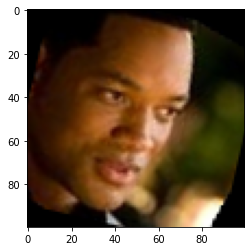

In [35]:
n = 16500
print(label_encoder.classes_[y_train[n]])
plt.imshow(X_train[n])

In [37]:
import os

out_dir = f'{dataset_folder}/preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
train.to_csv(os.path.join(out_dir, 'train.csv'), index=False)
np.save(os.path.join(out_dir, 'train_data.npy'), X_train)
np.save(os.path.join(out_dir, 'train_labels.npy'), y_train)

validation.to_csv(os.path.join(out_dir, 'validation.csv'), index=False)
np.save(os.path.join(out_dir, 'validation_data.npy'), X_validation)
np.save(os.path.join(out_dir, 'validation_labels.npy'), y_validation)

test.to_csv(os.path.join(out_dir, 'test.csv'), index=False)
np.save(os.path.join(out_dir, 'test_data.npy'), X_test)
np.save(os.path.join(out_dir, 'test_labels.npy'), y_test)

# 4. Modelos

In [119]:
input_shape = X_train.shape[1:]
n_classes = len(np.unique(y_train))

In [120]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [122]:
def fit_model(model, optimizer, X_train, y_train, X_validation, y_validation):
    loss = 'sparse_categorical_crossentropy'
    metrics = ['accuracy']
    
    early_stopping_patience = 10
    
    epochs = 100
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model.summary()
    
    early_stopping_cb = EarlyStopping(
        patience=early_stopping_patience,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_validation, y_validation),
        callbacks=[early_stopping_cb]
    )
    
    return history

In [123]:
def plot_history(history):
    history_df = pd.DataFrame(history.history)
    
    fig, axes = plt.subplots(2, figsize=(10, 10))

    history_df[['loss', 'val_loss']].plot(ax=axes[0], grid=True)
    history_df[['accuracy', 'val_accuracy']].plot(ax=axes[1], grid=True)

    plt.setp(axes, xticks=range(len(history_df)))
    plt.show()

## 4.1 Modelo do zero

Model: "From_Scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 97, 97, 32)        1568      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 32)        16416     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 15488)             0         
                                                                 
 dense_16 (Dense)            (None, 256)              

2022-06-19 18:56:24.628937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - ETA: 0s - loss: 4.4083 - accuracy: 0.0167

2022-06-19 18:56:41.182919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - 18s 33ms/step - loss: 4.4083 - accuracy: 0.0167 - val_loss: 4.3807 - val_accuracy: 0.0205
Epoch 2/100
519/519 [==============================] - 16s 30ms/step - loss: 4.2589 - accuracy: 0.0422 - val_loss: 4.1375 - val_accuracy: 0.0572
Epoch 3/100
519/519 [==============================] - 16s 30ms/step - loss: 3.8961 - accuracy: 0.0949 - val_loss: 3.7995 - val_accuracy: 0.1030
Epoch 4/100
519/519 [==============================] - 16s 30ms/step - loss: 3.5165 - accuracy: 0.1602 - val_loss: 3.4599 - val_accuracy: 0.1711
Epoch 5/100
519/519 [==============================] - 15s 30ms/step - loss: 3.0929 - accuracy: 0.2467 - val_loss: 3.1915 - val_accuracy: 0.2151
Epoch 6/100
519/519 [==============================] - 15s 30ms/step - loss: 2.6058 - accuracy: 0.3538 - val_loss: 2.8747 - val_accuracy: 0.2964
Epoch 7/100
519/519 [==============================] - 15s 30ms/step - loss: 2.1517 - accuracy: 0.4552 - val_loss: 2.6028 - val_accuracy: 0.36

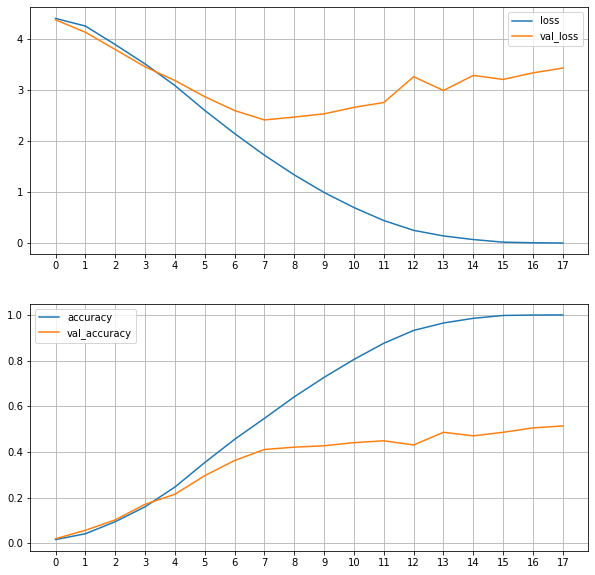

In [125]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import SGD

model_from_scratch = Sequential([
    Conv2D(filters=32, kernel_size=(4,4), input_shape=input_shape, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(4,4), activation='relu'),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),

    Dense(256, activation='relu'),
    Dense(n_classes, activation='softmax')
], name="From_Scratch")

history = fit_model(
    model=model_from_scratch,
    optimizer=SGD(learning_rate=0.01),
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation
)

plot_history(history)

## 4.2 Modelo de transfer learning

Model: "From_Scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 4608)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               1179904   
                                                                 
 dense_19 (Dense)            (None, 83)                21331     
                                                                 
Total params: 15,915,923
Trainable params: 1,201,235
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100


2022-06-19 19:05:19.524158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - ETA: 0s - loss: 3.5014 - accuracy: 0.1592

2022-06-19 19:06:27.890721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - 75s 145ms/step - loss: 3.5014 - accuracy: 0.1592 - val_loss: 2.9203 - val_accuracy: 0.2596
Epoch 2/100
519/519 [==============================] - 76s 147ms/step - loss: 2.4354 - accuracy: 0.3739 - val_loss: 2.6037 - val_accuracy: 0.3265
Epoch 3/100
519/519 [==============================] - 81s 156ms/step - loss: 1.9527 - accuracy: 0.4942 - val_loss: 2.3674 - val_accuracy: 0.3940
Epoch 4/100
519/519 [==============================] - 83s 160ms/step - loss: 1.6101 - accuracy: 0.5791 - val_loss: 2.2579 - val_accuracy: 0.4247
Epoch 5/100
519/519 [==============================] - 85s 163ms/step - loss: 1.3548 - accuracy: 0.6436 - val_loss: 2.2410 - val_accuracy: 0.4349
Epoch 6/100
519/519 [==============================] - 85s 164ms/step - loss: 1.1368 - accuracy: 0.7040 - val_loss: 2.2147 - val_accuracy: 0.4458
Epoch 7/100
519/519 [==============================] - 85s 164ms/step - loss: 0.9655 - accuracy: 0.7460 - val_loss: 2.1926 - val_accurac

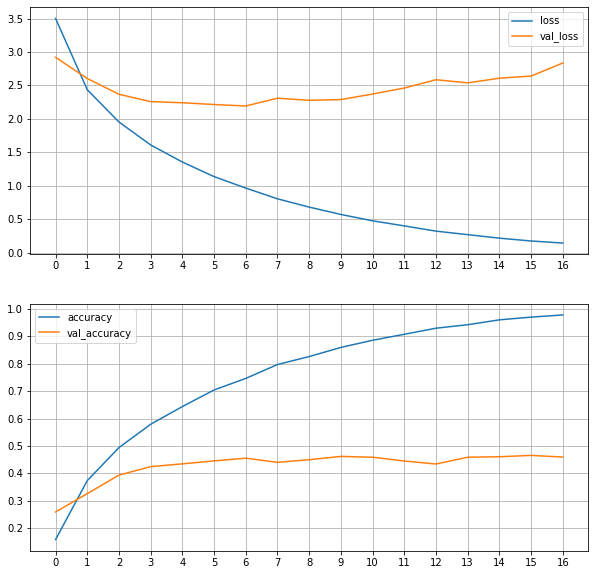

In [126]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

base_model_vgg16_imagenet = VGG16(
    include_top=None,
    weights="imagenet",
    input_shape=input_shape
)
base_model_vgg16_imagenet.trainable = False

model_vgg16_imagenet = Sequential([
    base_model_vgg16_imagenet,

    Flatten(),

    Dense(256, activation='relu'),
    Dense(n_classes, activation='softmax')
], name="Transfer_Learning")

history = fit_model(
    model=model_vgg16_imagenet,
    optimizer=Adam(learning_rate=0.001),
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation
)

plot_history(history)

## 4.3 Feat extractor e SVM

In [127]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16

base_model_vgg16_imagenet = VGG16(
    include_top=None,
    weights="imagenet",
    input_shape=input_shape
)
base_model_vgg16_imagenet.trainable = False

model_vgg16_imagenet = Sequential([
    base_model_vgg16_imagenet,
    Flatten()
], name="Feat_Extractor")

X_train_extracted = model_vgg16_imagenet.predict(X_train)
X_validation_extracted = model_vgg16_imagenet.predict(X_validation)

  1/519 [..............................] - ETA: 2:23

2022-06-19 19:29:41.373870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 7s 142ms/step


In [128]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=0.01, verbose=100)
svm.fit(X_train_extracted, y_train)

y_validation_pred = svm.predict(X_validation_extracted)

[LibLinear]
systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

..........................*.*
optimization finished, #iter = 272
Objective value = -2.038305
nSV = 1025
...........................*
optimization finished, #iter = 279
Objective value = -1.633774
nSV = 883
.............................**.*
optimization finished, #iter = 301
Objective value = -3.077884
nSV = 1401
...............................*
optimization finished, #iter = 312
Objective value = -3.346699
nSV = 1554
.............................*
optimization finished, #iter = 295
Objective value = -2.204754
nSV = 1129
...........................**
optimization finished, #iter = 277
Objective value = -1.871286
nSV = 821
..........................*
optimization finished, #iter = 265
Objective value = -1.579700
nSV = 846
............................*
optimization finished, #iter = 283
Objective value = -2.559909
nSV = 1192
.............................*
optimization finished, #iter = 292
Objective value = -2.653952
nSV = 1266
...

In [129]:
from sklearn.metrics import classification_report

class_names = label_encoder.classes_

print(classification_report(y_validation, y_validation_pred, target_names=[name for name in class_names]))

                      precision    recall  f1-score   support

        Adam Sandler       0.65      0.65      0.65        20
        Alec Baldwin       0.53      0.50      0.51        20
      Angelina Jolie       0.26      0.30      0.28        20
     Anna Kournikova       0.45      0.45      0.45        20
      Ashton Kutcher       0.42      0.40      0.41        20
       Avril Lavigne       0.50      0.75      0.60        20
        Barack Obama       0.71      0.75      0.73        20
         Ben Affleck       0.54      0.35      0.42        20
     Beyonce Knowles       0.40      0.30      0.34        20
           Brad Pitt       0.30      0.40      0.34        20
        Cameron Diaz       0.33      0.45      0.38        20
      Cate Blanchett       0.38      0.40      0.39        20
     Charlize Theron       0.26      0.25      0.26        20
     Christina Ricci       0.75      0.60      0.67        20
    Claudia Schiffer       0.67      0.60      0.63        20
       